<a href="https://colab.research.google.com/github/Yash1289/rossmann_sales_prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

**Regression analysis** is a fundamental concept in the field of machine learning . It falls under supervised learning wherein the alogrithms is trained with both input features and output labels. 

Specifically regression analysis is all about data. It helps businesses understand the data points they have and use them – specifically the relationships between data points – to make better decisions, including anything from predicting sales to understanding inventory levels and supply and demand.

In this project we as well will try to predict the future daily sales of Rossmann store for up to six weeks in advance , for the project we have at our disposal two database named *Rossmann Stores Data* that contains all the historical data including sales and the other one called *store* that contains supplemental information about all the stores

For this project we are going to use
  1. Numpy :- For its linear algebra functions and the advantage it offers over list in terms of speed and memory consumed
  2. Pandas :- This will be our primary data analysis library necessary for almost all of our data manipulations jobs
  3. Matplotlib :- Basic visualization library that we need for plotting and graphs
  4. Seaborn :- For more customizable and advanced data visualization
  5. Sklearn :- For all the models and tools that we need for our predictive data analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
#Mounting our google drive so we can acess the files in it through our google collab noteboook

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Reading the first database (Rossmann Stores Data) from our google drive

path1 = "/content/drive/MyDrive/Rossmann Stores Data.csv"
rossmann_df = pd.read_csv(path1 , low_memory = False)

In [ ]:
#Reading the second database (store) from our google drive

path2 = "/content/drive/MyDrive/store.csv"
store_df = pd.read_csv(path2)

### **Now we will perform some basic data exploration such as**


*   Checking the head of the database to gain some general idea about the nature of the database 
*   Finding  out its shape to know how many observations and features are in our dataset
*   We will also call `.columns` , `value_counts` and `.unique` like  methods and functions on both of our datasets so that we can understand all the features better

In [ ]:
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
#Checking the list of features we have in our first dataset
rossmann_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [ ]:
rossmann_df.shape #For first dataset we have 1017209 rows and 9 features

(1017209, 9)

In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
#Checking the list of features we have in our second dataset
store_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
store_df.shape #For the 2nd dataset we have in total 1115 rows and 10 features

(1115, 10)

In [ ]:
#Checking the number of unique stores that we have and their frequency in our rossmann dataset
rossmann_df["Store"].value_counts()

1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: Store, Length: 1115, dtype: int64

As we can notice above we have in total 1115 unique stores in our rossmann dataset which is same as the number of observations we have in our store dataset

In [ ]:
#Checking the unique values we have in our DayOfWeek Column , and as it seems we have data for every day of the week
rossmann_df["DayOfWeek"].unique()

array([5, 4, 3, 2, 1, 7, 6])

In [ ]:
#Checking the datatypes of all the variables in our rossmann dataset

pd.DataFrame(rossmann_df.dtypes).rename(columns = {0:'dtype'})

,dtype
Store,int64
DayOfWeek,int64
Date,object
Sales,int64
Customers,int64
Open,int64
Promo,int64
StateHoliday,object
SchoolHoliday,int64


In [ ]:
pd.DataFrame(store_df.dtypes).rename(columns = {0:'dtype'})

,dtype
Store,int64
StoreType,object
Assortment,object
CompetitionDistance,float64
CompetitionOpenSinceMonth,float64
CompetitionOpenSinceYear,float64
Promo2,int64
Promo2SinceWeek,float64
Promo2SinceYear,float64
PromoInterval,object


### **Data cleaning and handling duplicate as well as null/na values**

In [ ]:
#Calling duplicated on our rossmann dataset to check if we have multiple data for a store on any choosen date
rossmann_df[rossmann_df.duplicated( subset = ["Store" , "Date"])]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


No duplicate data , which means we have just one observation for a particular store on any choosen date

Our data exploration till now helped us to know that in our rossmann dataset we have day wise sales data for 1115 unique stores and in our stores data we have 1115 observation , where each row contains supplemental information for a store in our rossmann dataset , so will left merge both the two datasets on the basis of store number

In [ ]:
rossmann_df = pd.merge(rossmann_df , store_df , how = "left" , on="Store")
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
#Changing the datatype of date column from string to a datetime object

rossmann_df["Date"] = pd.to_datetime(rossmann_df["Date"])

In [ ]:
#Checking the total number of null values we have in our merged dataset for each of the column
rossmann_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [ ]:
#Checking the time period of the dataset
max_date = rossmann_df["Date"].max()
min_date = rossmann_df["Date"].min()

print(f"{min_date}")
print(f"{max_date}")

2013-01-01 00:00:00
2015-07-31 00:00:00


As we can see the observations in our dataset is from 1st jan 2013 till 31st of july 2015

In [ ]:
#Making a copy of our dataset on which we will work on from hereafter
rossmann_sales_df = rossmann_df.copy()

In [ ]:
#Sorting our dataset on basis of date 
rossmann_sales_df = rossmann_sales_df.sort_values(by = "Date", ignore_index = True)
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,NaN,NaN,0,NaN,NaN,NaN
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,NaN,NaN,NaN
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,NaN,NaN,NaN


In [ ]:
#Checking if we have any data for which store is closed on that day
rossmann_sales_df[rossmann_sales_df["Open"] == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,NaN,NaN,0,NaN,NaN,NaN
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,NaN,NaN,NaN
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014546,876,3,2015-07-29,0,0,0,1,0,1,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov"
1015076,292,4,2015-07-30,0,0,0,1,0,1,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN
1015659,876,4,2015-07-30,0,0,0,1,0,1,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov"
1016191,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN


As we can see we have a fair amount of observation of days on which store is closed and as these observations doesn't provide us with any useful information regarding sales or customers we will drop them

In [ ]:
#Dropping all the observation of those days on which the stores are closed
closedStore_index = rossmann_sales_df[rossmann_sales_df["Open"] == 0].index
rossmann_sales_df.drop(closedStore_index , inplace = True )

#Dropping rows for which daily sales is equal to zero
zeroSale_index = rossmann_sales_df[rossmann_sales_df["Sales"] == 0].index
rossmann_sales_df.drop(zeroSale_index, inplace = True)

rossmann_sales_df.reset_index(drop = True , inplace = True)

In [ ]:
#Checking the shape of the data after dropping the rows above
rossmann_sales_df.shape

(844338, 18)

Now we have 844338 rows down from 1017209 that we had earlier

In [ ]:
#Finding the total number off null values for each feature that we have remaining in our dataset
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64


For rows that have null as their values for CompetitionDistance we will replace them with zero assumming those stores have no competitor stores nearby and if CompetitionDistance is zero CompetitionOpenSinceMonth and CompetitionOpenSinceYear columns will be zero as well

In [ ]:
#Filling the null values of CompetitionDistance with zero
rossmann_sales_df["CompetitionDistance"] = rossmann_sales_df["CompetitionDistance"].fillna(0)

#filling the null values of CompetitionOpenSinceMonth and CompetitonOpenSinceYear to 0 for all the observations where Competition Distance is equal to zero
rossmann_sales_df["CompetitionOpenSinceMonth"] = np.where(rossmann_sales_df["CompetitionDistance"].isna() , 0 , rossmann_sales_df["CompetitionOpenSinceMonth"])
rossmann_sales_df["CompetitionOpenSinceYear"] = np.where(rossmann_sales_df["CompetitionDistance"].isna() , 0 , rossmann_sales_df["CompetitionOpenSinceYear"])


In [ ]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

Now for the null values of CompetitionOpenSinceMonth and CompetitionOpenSinceYear we can take two approach
1. Replace them with median values 
2. Replace null values with mean of their respective columns 

Out of these two approach which to taketo take depends on the distribution of the columsn if we have extreme outliers we will use the first method and if not then second works fine

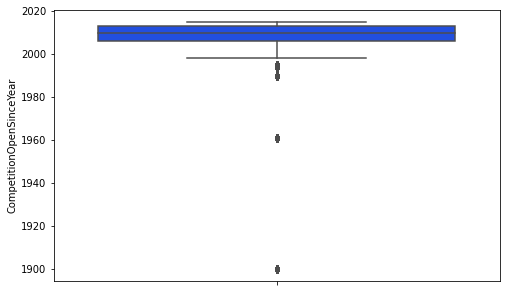

In [ ]:
#Checking the distribution of CompetitionOpenSinceYear columns for observations where it is not zero 
import seaborn as sns
plt.figure(figsize = (8,5))
sns.boxplot( y = "CompetitionOpenSinceYear" , data = rossmann_sales_df[rossmann_sales_df["CompetitionOpenSinceYear"] != 0 ], palette = "bright")

We can notice above that we have some extreme outliers with values going as low as 1900 and hence we will replace values with median not mean

In [ ]:
#Replacing all the null values of CompetitionOpenSinceMonth and CompetitionOpenSinceYear columns with median values
rossmann_sales_df["CompetitionOpenSinceYear"] = np.where(rossmann_sales_df["CompetitionOpenSinceYear"].isna() , rossmann_sales_df["CompetitionOpenSinceYear"].median() , rossmann_sales_df["CompetitionOpenSinceYear"])
rossmann_sales_df["CompetitionOpenSinceMonth"] = np.where(rossmann_sales_df["CompetitionOpenSinceMonth"].isna() , rossmann_sales_df["CompetitionOpenSinceMonth"].median() , rossmann_sales_df["CompetitionOpenSinceMonth"])


In [ ]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

Now as in our dataset values for any store is time sensitive , we will set values of CompetitionDistance , CompetitionOpenSinceYear and CompetitionOpenSinceMonth to zero for those observations in which the date is before the date at which the nearby competitor store opened 

In [ ]:
#Iterating through all the rows and conditionally setting value of CompetitionDistance , CompetitionOpenSinceYear and CompetitionOpenSinceMonth to zero for which the condition is true
for index, row in rossmann_sales_df.iterrows():
  if row["Date"].year < row["CompetitionOpenSinceYear"] or(row["Date"].year == row["CompetitionOpenSinceYear"] and row["Date"].month < row["CompetitionOpenSinceMonth"]) :
    rossmann_sales_df.at[index, "CompetitionOpenSinceYear"] = 0 
    rossmann_sales_df.at[index, "CompetitionOpenSinceMonth"] = 0
    rossmann_sales_df.at[index, "CompetitionDistance"] = 0

In [ ]:
rossmann_sales_df[rossmann_sales_df["Promo2"] == 0][["Promo2SinceWeek" ,"Promo2SinceYear", "PromoInterval" ]]

,Promo2SinceWeek,Promo2SinceYear,PromoInterval
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
8,NaN,NaN,NaN
...,...,...,...
844328,NaN,NaN,NaN
844329,NaN,NaN,NaN
844334,NaN,NaN,NaN
844336,NaN,NaN,NaN


It is evident above that values of Promo2SinceWeek , Promo2SinceYear and PromoInterval are NaN only for those observations of stores which do not run Promo2 and hence having values of Promo2 equal to zero and so for these observations we will set null values of all the above three rows to zero as well 

In [ ]:
#Filling the null values of Promo2SinceWeek , Promo2SinceYear and PromoInterval to zero 
rossmann_sales_df["PromoInterval"] = rossmann_sales_df["PromoInterval"].fillna(0)
rossmann_sales_df["Promo2SinceWeek"] = rossmann_sales_df["Promo2SinceWeek"].fillna(0)
rossmann_sales_df["Promo2SinceYear"] = rossmann_sales_df["Promo2SinceYear"].fillna(0)

With the help of Promo2SinceWeek and Promo2SinceYear we can know when the promo2 started running at the store and so for observation of dates before the moment in time when Promo2 campaign started at the store we will set the values of Promo2 for those observation to zero

In [ ]:
def Promo2Running(row):

  '''Function to conditionally return different values for promo2 according to the date for which the observation is '''

  if row["Promo2"] != 0 :
    if ( row["Date"].year < row["Promo2SinceYear"] ) or ( row["Date"].year == row["Promo2SinceYear"] and row["Date"].month < (row["Promo2SinceWeek"]//4 +1)):
      return 0
    else:
      return 1
  else:
    return 0

In [ ]:
#Applying the Promo2Running function to refine the values of Promo2 for each of the observation
rossmann_sales_df["Promo2"] = rossmann_sales_df.apply(Promo2Running , axis = 1)

### **Feature Engineering**

Feature engineering is basically a process in which we select and transfrom varibles into features that better represent the underlying problem to the predictive models

The goal is to create the best representation of our sample data to learn a solution to our problem at hand 

In [ ]:
def MonthsOfCompetition(row):

  '''Function to find the number of months that has passed for any store since the nearby competitor store opened'''
  
  if row["CompetitionOpenSinceYear"] != 0:
    return ((row["Date"].year - row["CompetitionOpenSinceYear"])*12 + (row["Date"].month - row["CompetitionOpenSinceMonth"]))
  else:
    return 0

In [ ]:
#Creating a new row named NumberOfMonthsFacedCompetition that will denote the number of months since the nearby competitor store opened
rossmann_sales_df["NumberOfMonthsFacedCompetition"] = rossmann_sales_df.apply(MonthsOfCompetition , axis = 1)

In [ ]:
#Dropping the rows CompetitionOpenSinceMonth and CompetitionOpenSinceYear from our dataset
rossmann_sales_df.drop(["CompetitionOpenSinceMonth" , "CompetitionOpenSinceYear"] , axis = 1 , inplace = True )

In [ ]:
def PromoMonth(row):

  '''Function to check if the month for which the observation is matches with the promo2 month or not'''

  if isinstance(row["PromoInterval"], str):
    if row["Date"].strftime("%b") in row["PromoInterval"].split(","):
      return 1
    else:
      return 0
  else:
    return -1


The above function returns 1 for for those dates whose month matches with the months for which Promo2 runs in that store , 0 if the store participates in Promo2 but date for which the observation is not in the list of month for which Promo2 runs in that store and it returns if the store doesn't participates in Promo2 

In [ ]:
#Creating a new feature named isPromoMonth which denotes whether the Promo2 is running on that day at the store
rossmann_sales_df["isPromoMonth"] = rossmann_sales_df.apply(PromoMonth ,axis = 1)

In [ ]:
#Dropping column PromoInterval from the dataset
rossmann_sales_df.drop(["PromoInterval"] , axis=1 , inplace = True)

In [ ]:
#Delete this one as well
rossmann_sales_df["isPromoMonth"].value_counts()

-1    423292
 0    280897
 1    140149
Name: isPromoMonth, dtype: int64

In [ ]:
#Most probably this cell of code will be deleted if somehow i forgot to delete this then please don't mind and forget me
rossmann_sales_df["isPromoMonth"] = np.where(rossmann_sales_df["Promo2"] == 0 , -1 , rossmann_sales_df["isPromoMonth"])

In [ ]:
#This one will be deleted as well 
rossmann_sales_df["isPromoMonth"].value_counts()

-1    481165
 0    241357
 1    121816
Name: isPromoMonth, dtype: int64

In [ ]:
def MonthsPromo2(row):

  '''Function to find the number of months that has passed since Promo2 started running at the store'''

  if row["Promo2"] != 0:
    return (( row["Date"].year - row["Promo2SinceYear"])*12 + (row["Date"].month - (row["Promo2SinceWeek"]//4 +1)))
  else:
    return 0

In [ ]:
#Creating a new feature named MonthsOfPromo2 to denote the number of months since when Promo2 is running on the store
rossmann_sales_df["MonthsOfPromo2"] = rossmann_sales_df.apply(MonthsPromo2 , axis = 1)

In [ ]:
#Dropping columns Promo2SinceYear and Promo2SinceWeek from the dataset
ossmann_sales_df.drop(["Promo2SinceYear" , "Promo2SinceWeek"] , axis = 1 , inplace = True )

In [ ]:
#Checking the head of the database to view all the transformation that we performed above
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2
0,353,2,2013-01-01,3139,820,1,0,a,1,b,b,0.0,0,0.0,-1,0.0
1,335,2,2013-01-01,2401,482,1,0,a,1,b,a,0.0,0,0.0,-1,0.0
2,512,2,2013-01-01,2646,625,1,0,a,1,b,b,0.0,0,0.0,-1,0.0
3,494,2,2013-01-01,3113,527,1,0,a,1,b,a,1260.0,0,19.0,-1,0.0
4,530,2,2013-01-01,2907,532,1,0,a,1,a,c,0.0,0,0.0,-1,0.0


In [ ]:
#Extracting month and year from our Date column and creating separate columns for them
rossmann_sales_df["Month"] = rossmann_sales_df["Date"].apply(lambda x : x.month)
rossmann_sales_df["Year"] = rossmann_sales_df["Date"].apply(lambda x : x.year)

In [ ]:
#Creating a new copy of our database on which we will work from hereafter
rossmann_model_df = rossmann_sales_df.copy()

In [ ]:
#Grouping our database based on Store , Month and Year and 
rossmannSales_groupby = rossmann_model_df.groupby(["Store" , "Month" , "Year"]).agg({ "Sales" : "mean" , "Customers" : "mean" }).reset_index()

In [ ]:
grouped_df = rossmannSales_groupby.sort_values(by = [ "Store" , "Year" , "Month" ] ,ignore_index="True")
grouped_df.head()

,Store,Month,Year,Sales,Customers
0,1,1,2013,4939.653846,611.500000
1,1,2,2013,5219.625000,632.875000
2,1,3,2013,5806.760000,702.960000
3,1,4,2013,4720.360000,575.280000
4,1,5,2013,5140.217391,607.173913


In [ ]:
grouped_df.shape

(33465, 5)

In [ ]:
listOfStores = grouped_df["Store"].unique()

In [ ]:
shifted_df = grouped_df.copy()

for storeNo in listOfStores :
  shifted_df.loc[shifted_df["Store"] == storeNo , "Sales" ] = shifted_df[shifted_df["Store"] == storeNo ]["Sales"].shift( periods=2, fill_value=0 )
  shifted_df.loc[shifted_df["Store"] == storeNo , "Customers" ] = shifted_df[shifted_df["Store"] == storeNo ]["Customers"].shift( periods = 2 , fill_value = 0)


In [ ]:
shifted_df.rename(columns = {"Sales" : "2MonthAgoSale" , "Customers" : "2MonthAgoCustomers" } ,inplace = True)

In [ ]:
shifted_df.head()

,Store,Month,Year,2MonthAgoSale,2MonthAgoCustomers
0,1,1,2013,0.000000,0.000
1,1,2,2013,0.000000,0.000
2,1,3,2013,4939.653846,611.500
3,1,4,2013,5219.625000,632.875
4,1,5,2013,5806.760000,702.960


In [ ]:
rossmann_model_df = pd.merge(rossmann_model_df , shifted_df , how = "left" , on = ["Store" , "Month" , "Year"])

In [ ]:
index_places1 = rossmann_model_df[rossmann_model_df["2MonthAgoSale"] == 0].index
rossmann_model_df.drop( index_places1 , inplace = True )

In [ ]:
rossmann_temp_df = rossmann_model_df.copy()

In [ ]:
rossmann_temp_df = pd.get_dummies( rossmann_temp_df , columns = ["StoreType" , "Assortment" ] , prefix = [ "StoreType" , "Assortment_type" ])

In [ ]:
encoder_nums = { "StateHoliday" : { "0" : 0 , "a" : 1 , "b" : 3 , "c" : 2} } 

rossmann_temp_df = rossmann_temp_df.replace(encoder_nums)

In [ ]:
rossmann_temp_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2,Month,Year,2MonthAgoSale,2MonthAgoCustomers,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_type_a,Assortment_type_b,Assortment_type_c
55547,373,5,2013-03-01,4074,308,1,0,0,0,0.0,1,0.0,0,9.0,3,2013,3795.307692,277.923077,0,0,0,1,0,0,1
55548,369,5,2013-03-01,6643,542,1,0,0,0,0.0,0,0.0,-1,0.0,3,2013,6424.153846,528.769231,0,0,0,1,0,0,1
55549,370,5,2013-03-01,7152,645,1,0,0,0,8250.0,1,149.0,0,43.0,3,2013,6823.461538,571.192308,0,0,0,1,1,0,0
55550,371,5,2013-03-01,5774,473,1,0,0,0,1970.0,0,44.0,-1,0.0,3,2013,6373.846154,514.269231,0,0,0,1,0,0,1
55551,372,5,2013-03-01,8214,759,1,0,0,0,4880.0,0,31.0,-1,0.0,3,2013,7761.884615,702.000000,0,0,0,1,0,0,1


In [ ]:
rossmann_temp_df[rossmann_temp_df["isPromoMonth"] == -1]["Promo2"].unique()

array([0])

In [ ]:
rossmann_temp_df.shape

(788643, 25)

## Eda Section

In [ ]:
rossmann_eda_df = rossmann_sales_df.copy()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

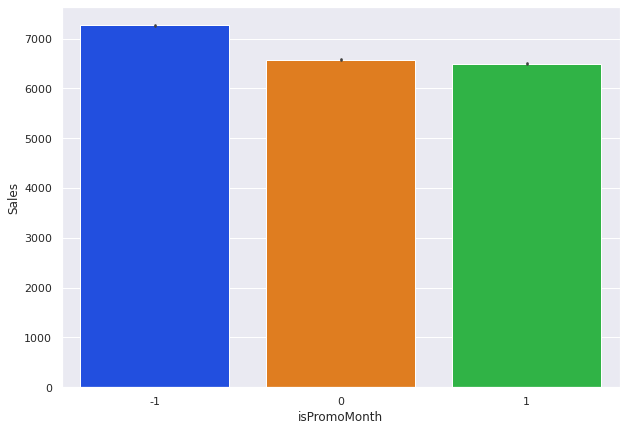

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='isPromoMonth' , y='Sales',data = rossmann_eda_df , palette = 'bright',estimator = np.mean)


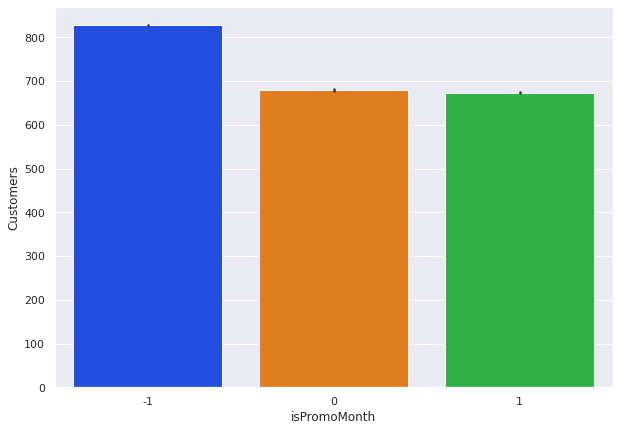

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='isPromoMonth' , y='Customers',data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

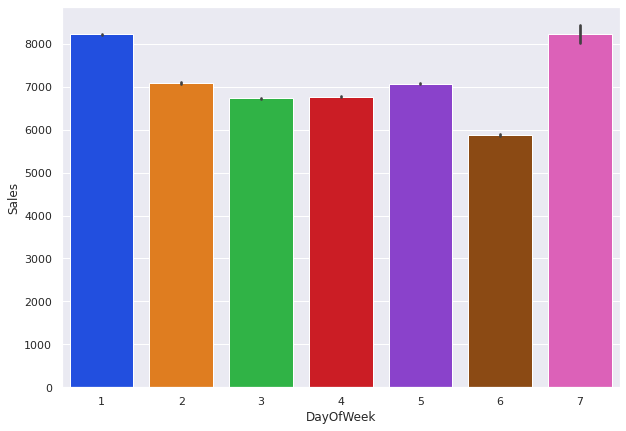

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='DayOfWeek',y='Sales',data = rossmann_eda_df , palette = 'bright',estimator = np.mean)


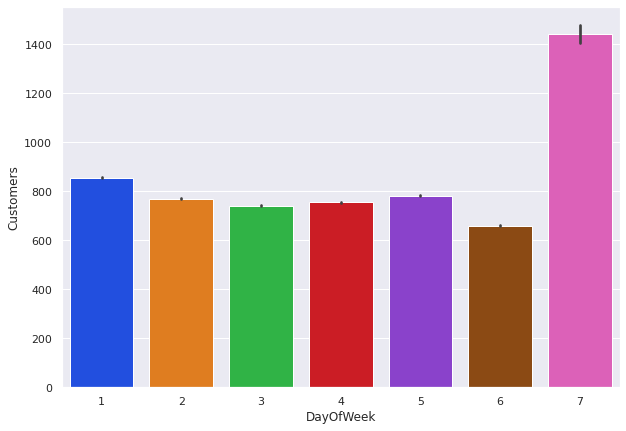

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='DayOfWeek',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

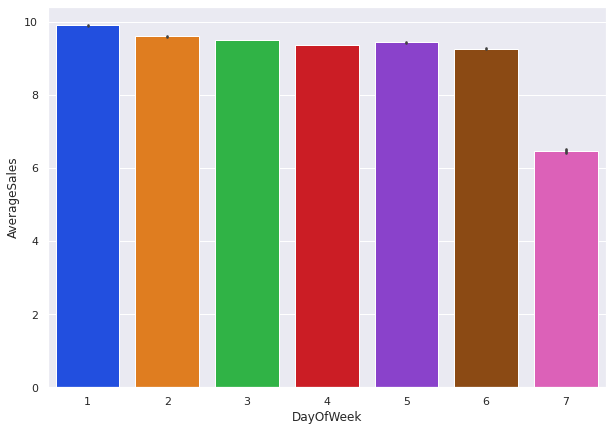

In [ ]:
rossmann_eda_df["AverageSales"] = rossmann_eda_df["Sales"]/rossmann_eda_df["Customers"]

plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='DayOfWeek', y='AverageSales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

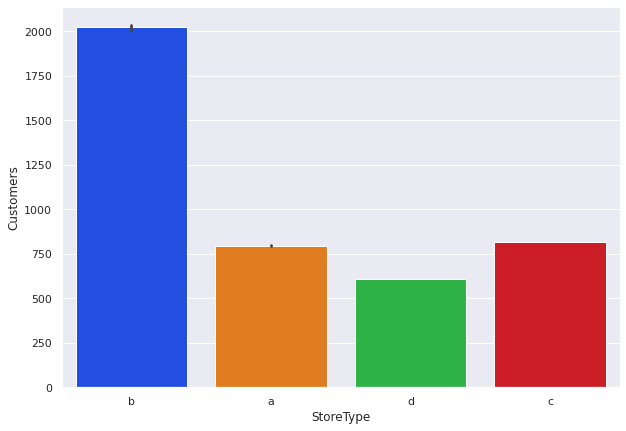

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='StoreType',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

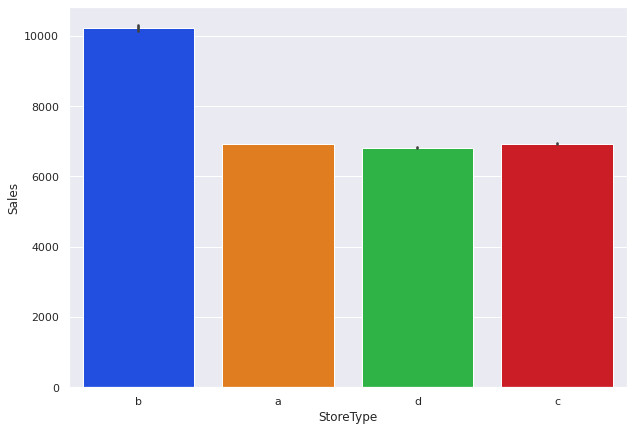

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='StoreType',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

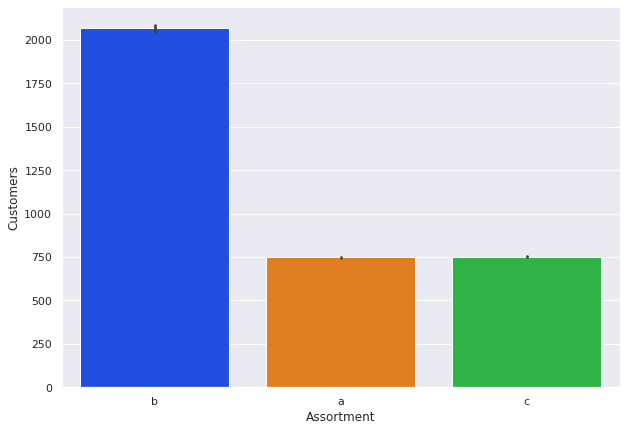

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='Assortment',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

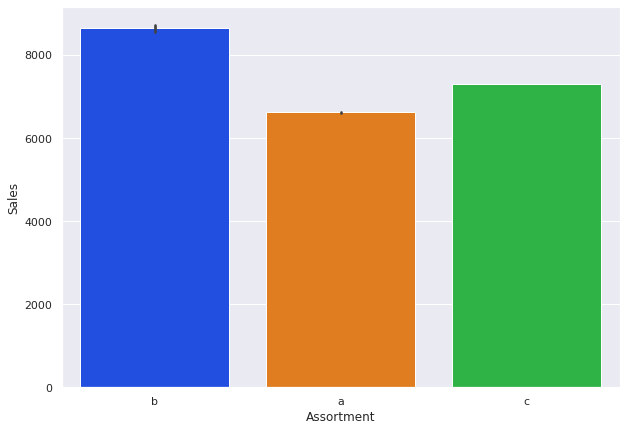

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='Assortment',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

In [ ]:
rossmann_eda_groupby = rossmann_eda_df.groupby(["StoreType" , "Assortment" , "Store"] , sort=False).agg({ "Date" : "first" }).reset_index()
rossmann_eda_groupby = rossmann_eda_groupby.groupby(["StoreType" , "Assortment"] , sort =False).agg({ "Store" : "count" }).reset_index()

rossmann_eda_pivot = rossmann_eda_groupby.pivot(index = "StoreType" , columns="Assortment" , values = "Store")
rossmann_eda_pivot

Assortment,a,b,c
StoreType,,,
a,381.0,NaN,221.0
b,7.0,9.0,1.0
c,77.0,NaN,71.0
d,128.0,NaN,220.0


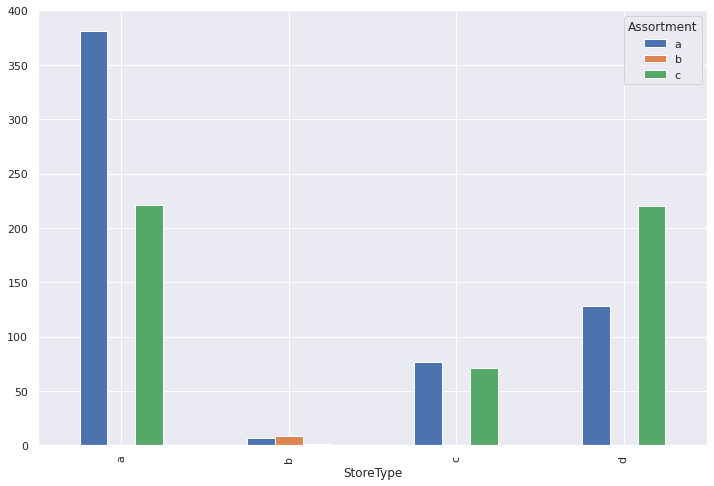

In [ ]:
plt.rcParams['figure.figsize'] = 8,5

rossmann_eda_pivot.fillna(0 , axis = 1 , inplace = True)
rossmann_eda_pivot.plot(kind="bar" , figsize=(12,8))

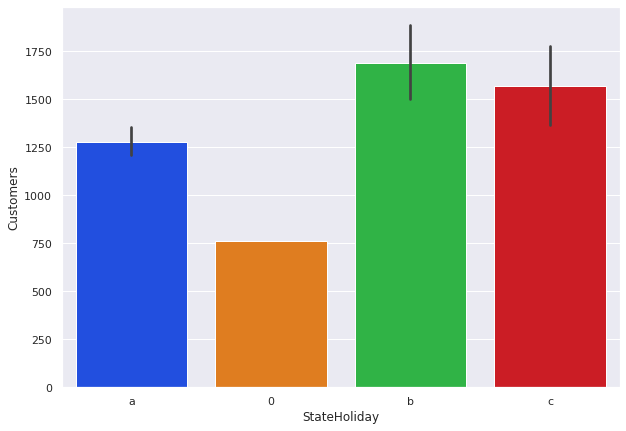

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='StateHoliday',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

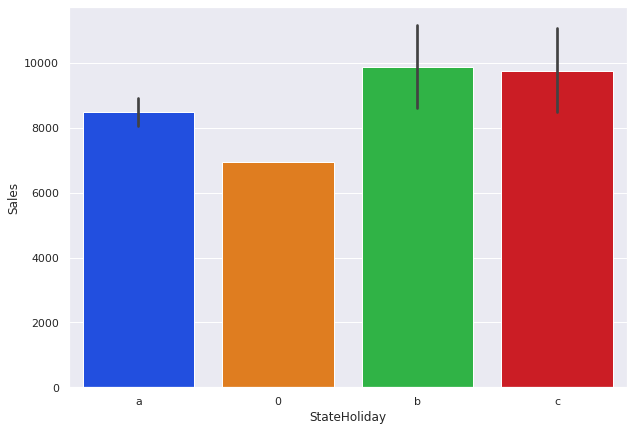

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='StateHoliday',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

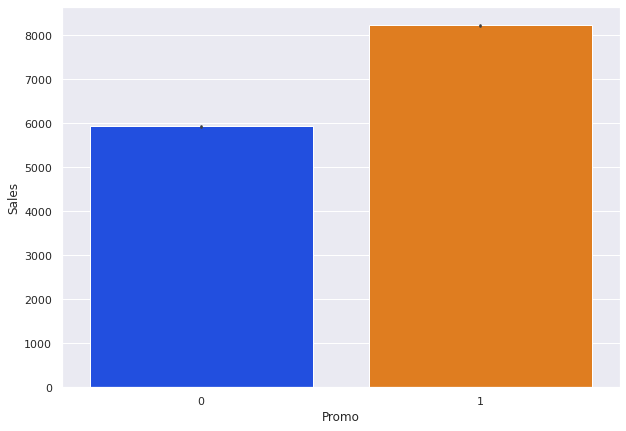

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='Promo',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

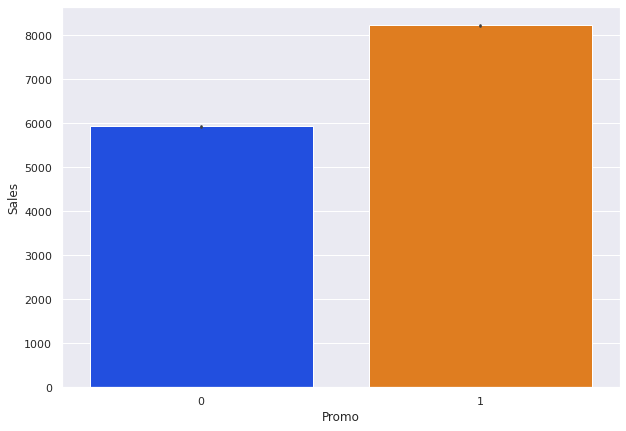

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='Promo',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
sns.barplot(x='Promo',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

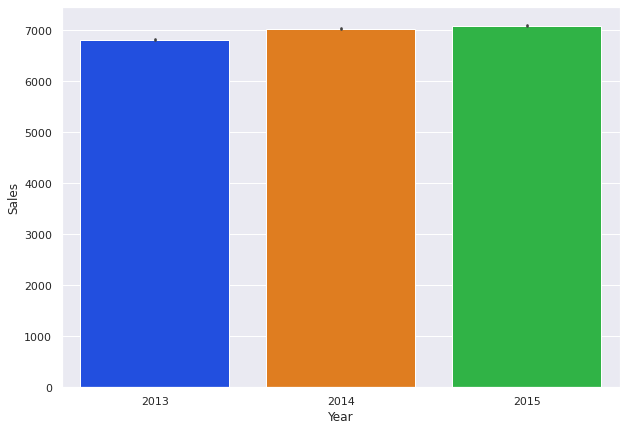

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='Year',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

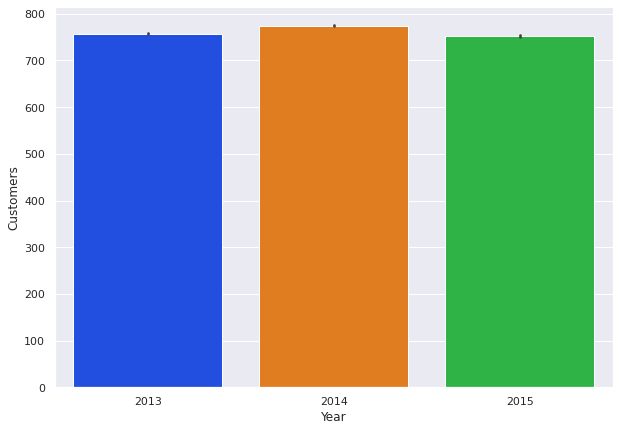

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='Year',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

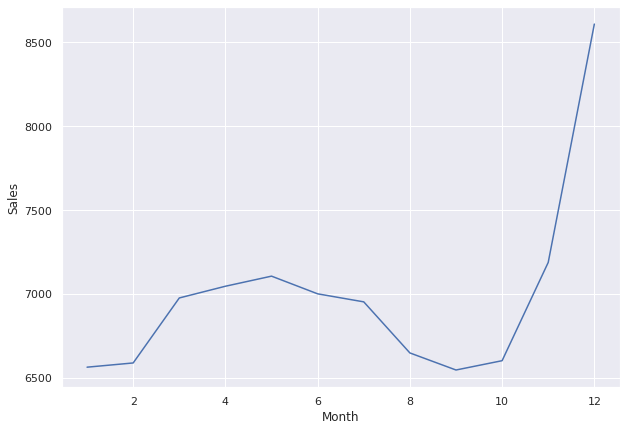

In [ ]:
rossmann_months_groupby = rossmann_eda_df.groupby("Month").agg({ "Sales" : "mean"}).reset_index()

plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.lineplot(x='Month',y= 'Sales' ,data = rossmann_months_groupby , palette = 'bright' ,estimator = np.mean )

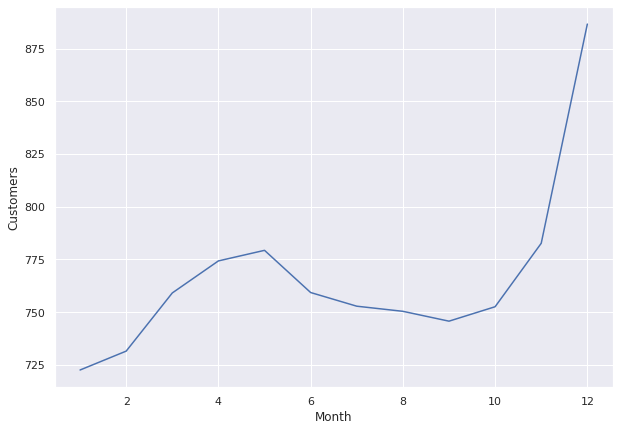

In [ ]:
rossmann_months_groupby = rossmann_eda_df.groupby("Month").agg({ "Customers" : "mean"}).reset_index()

plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.lineplot(x='Month',y= 'Customers' ,data = rossmann_months_groupby , palette = 'bright' )

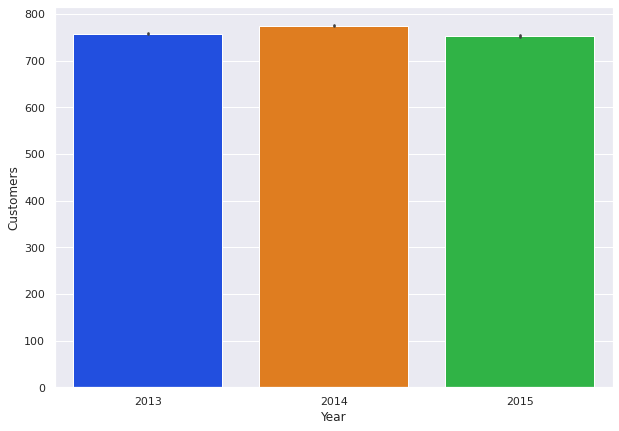

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='Year',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright' ,estimator =np.mean )

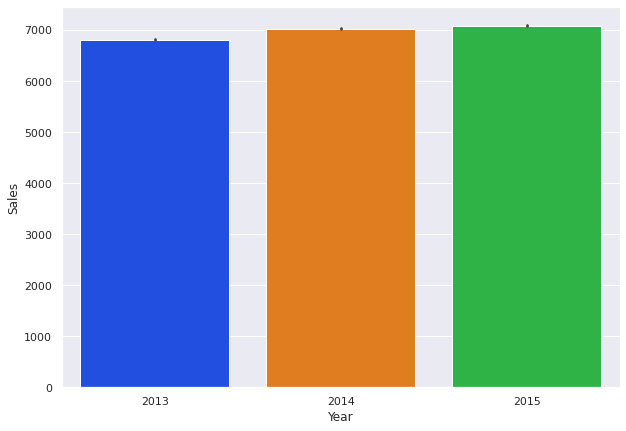

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='Year',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright' ,estimator =np.mean )

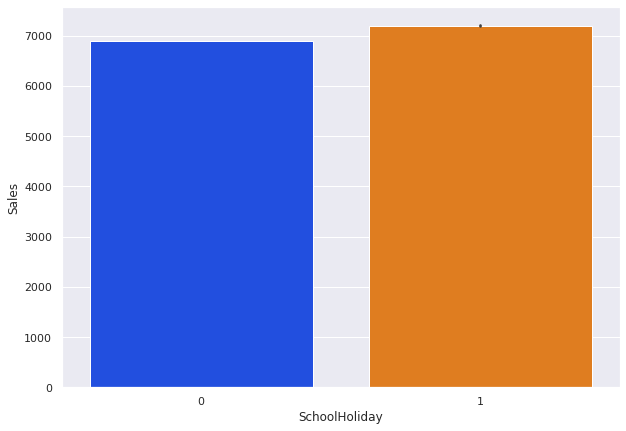

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='SchoolHoliday',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright' ,estimator =np.mean )

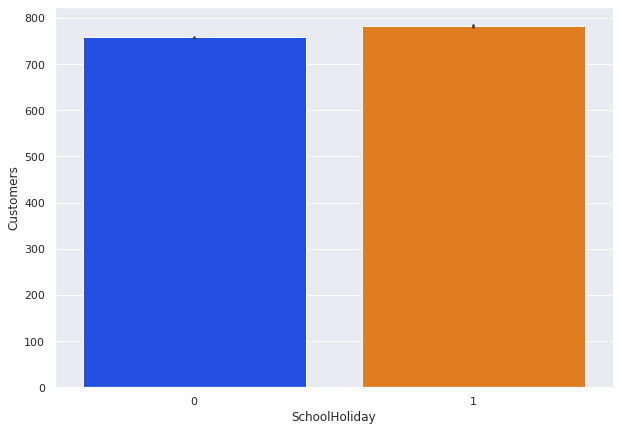

In [ ]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='SchoolHoliday',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright' ,estimator =np.mean )

In [ ]:
def ScatterPlotFunc(x , y, data):
  correlation = data[x].corr(data[y])
  plt.rcParams['figure.figsize'] = 10,7
  sns.set_context('paper', font_scale=1.4)
  sns.set_theme(style='darkgrid')
  sns.scatterplot(x = x ,y= y ,data = data , palette = 'bright' )
  z = np.polyfit(data[x] , data[y] , 1)
  y_hat = np.polyval( z , data[x])
  plt.plot(data[x] , y_hat ,"r--", lw=1 )
  plt.title(f'{x} vs {y} correlation :- {correlation}')

<function matplotlib.pyplot.show>

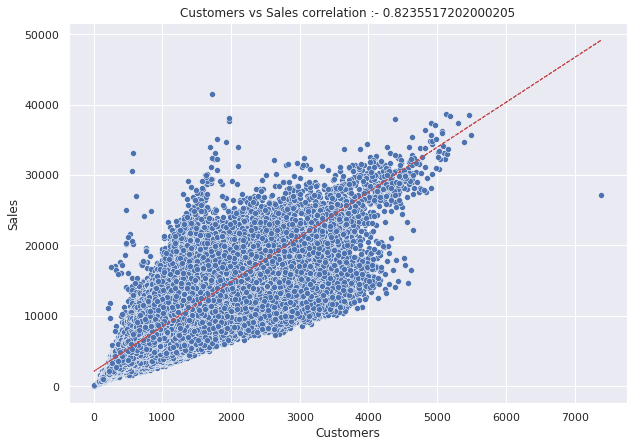

In [ ]:
ScatterPlotFunc("Customers" , "Sales" , rossmann_eda_df )

plt.show

<function matplotlib.pyplot.show>

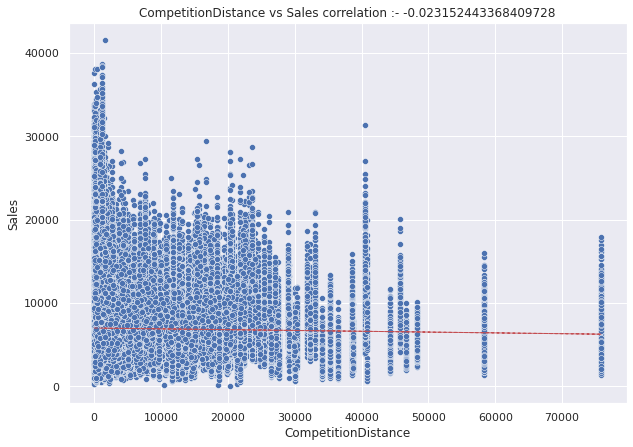

In [ ]:

ScatterPlotFunc("CompetitionDistance" ,"Sales" , rossmann_eda_df)

plt.show

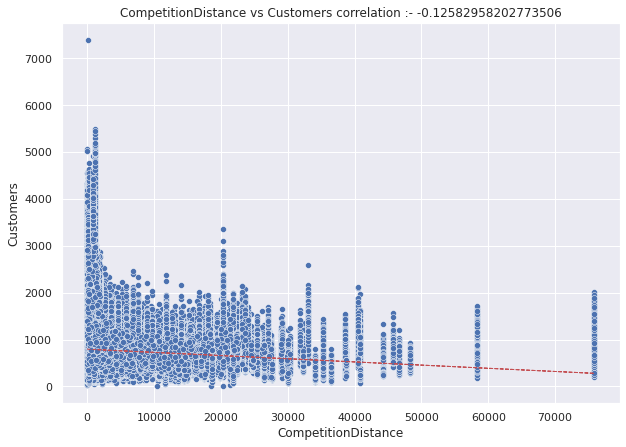

In [ ]:
ScatterPlotFunc("CompetitionDistance" , "Customers" , rossmann_eda_df)

<function matplotlib.pyplot.show>

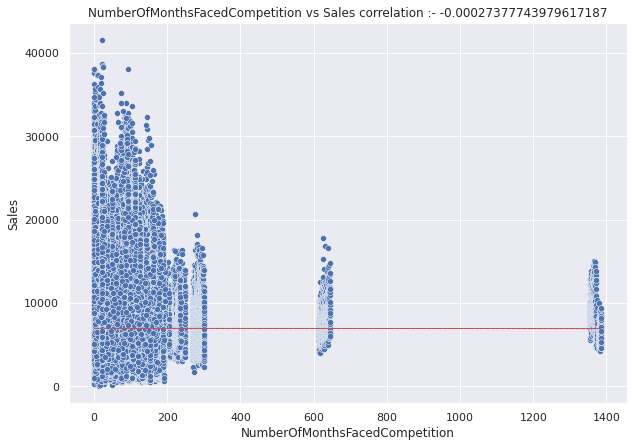

In [ ]:
ScatterPlotFunc("NumberOfMonthsFacedCompetition" , "Sales" , rossmann_eda_df)
plt.show

In [ ]:
rossmann_eda_df_groupby = rossmann_eda_df.groupby(["StoreType" , "Store"] , sort =False).agg({ "Date" : "first"}).reset_index()
EachStoreTypeCount = rossmann_eda_df_groupby["StoreType"].value_counts()
EachStoreTypeCount

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

Text(0.5, 1.0, 'No of stores across different store types')

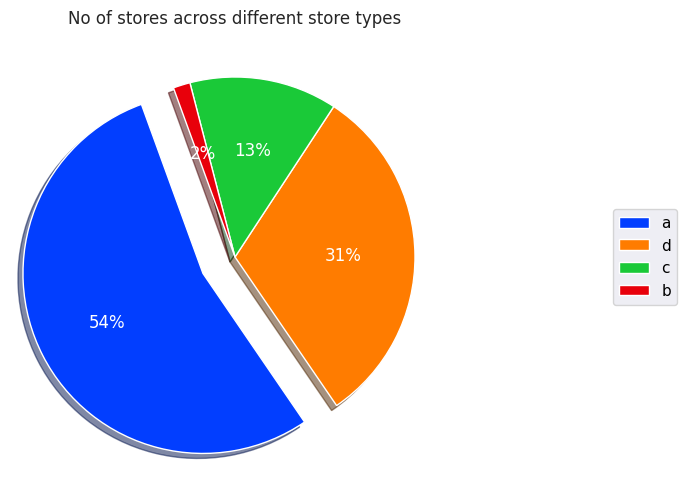

In [ ]:
#Finding out the number of apps that we have in each category bracket

rossmann_eda_df_groupby = rossmann_eda_df.groupby(["StoreType" , "Store"] , sort =False).agg({ "Date" : "first"}).reset_index()
EachStoreTypeCount = rossmann_eda_df_groupby["StoreType"].value_counts()

#Making a list of all Categories
EachStoreTypeCount_list = EachStoreTypeCount.index.tolist()
#Making a list of count of apps that each category has 
EachStoreTypeCount_count = list(EachStoreTypeCount.values)

''' hh '''


totalStoreTypes = len(EachStoreTypeCount_count)

fig_1 = plt.figure(figsize=(8,5),dpi=100)
axes_1 = fig_1.add_axes([0.1,0.1,0.9,0.9])
plt.rcParams['text.color'] = 'black'
colors = sns.color_palette('bright')[0:totalStoreTypes]

explode = [0]*totalStoreTypes
explode[0] = 0.2

wedges, texts, autotexts = plt.pie(EachStoreTypeCount_count, explode=explode, labels = EachStoreTypeCount_list, colors=colors, 
                                    autopct='%1.0f%%', shadow=True, startangle=110, 
                                    textprops=dict(color="w"))

plt.legend(wedges, EachStoreTypeCount_list, loc='right', bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("No of stores across different store types")


In [ ]:
rossmann_eda_df_groupby = rossmann_eda_df.groupby(["Assortment" , "Store"] , sort =False).agg({ "Date" : "first"}).reset_index()
EachAssortmentLevelCount = rossmann_eda_df_groupby["Assortment"].value_counts()
EachAssortmentLevelCount

a    593
c    513
b      9
Name: Assortment, dtype: int64

In [ ]:
promo_month = rossmann_eda_df.loc[: , ["Date" , "Year" ,"Month", "Promo"]]
promo_month["Day"] = promo_month["Date"].apply(lambda x : x.day)
promo_month.head()

,Date,Year,Month,Promo,Day
0,2013-01-01,2013,1,0,1
1,2013-01-01,2013,1,0,1
2,2013-01-01,2013,1,0,1
3,2013-01-01,2013,1,0,1
4,2013-01-01,2013,1,0,1


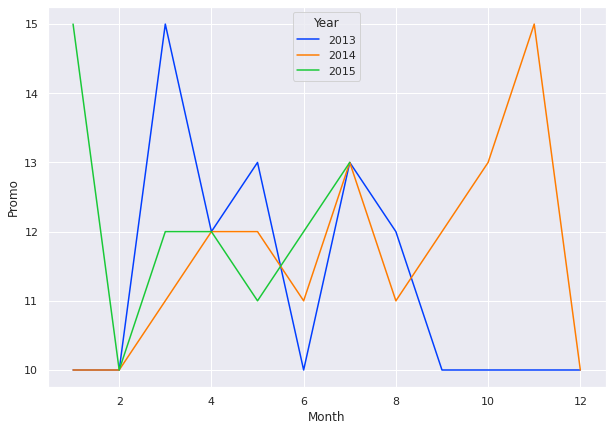

In [ ]:
promo_month_groupby = promo_month.groupby(["Year" , "Month" , "Day"]).agg({ "Promo" : "first"  }).reset_index().groupby(["Year" , "Month"]).agg({ "Promo" : "sum"}).reset_index()
sns.lineplot(x = "Month" , y = "Promo" , hue = "Year" , data = promo_month_groupby , palette = 'bright' )

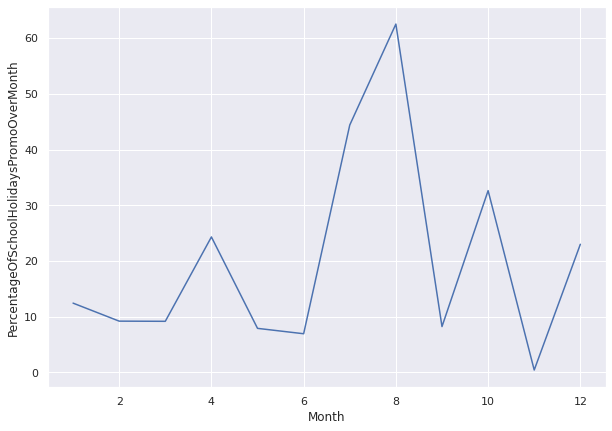

In [ ]:
school_holiday_groupby = rossmann_eda_df.groupby(["Month"] , sort = False).agg(Count =('SchoolHoliday', 'count'), Sum=('SchoolHoliday', 'sum')).reset_index()
school_holiday_groupby["PercentageOfSchoolHolidaysPromoOverMonth"] = (school_holiday_groupby["Sum"]*100)/school_holiday_groupby["Count"]
sns.lineplot(x = "Month" , y = "PercentageOfSchoolHolidaysPromoOverMonth" , data = school_holiday_groupby , palette = "bright")


## Model Implementation Section

In [ ]:
numerical_features = [ "CompetitionDistance" , "NumberOfMonthsFacedCompetition" , "MonthsOfPromo2" ,"Customers" , "Sales" ,"2MonthAgoSale" ,"2MonthAgoCustomers"]

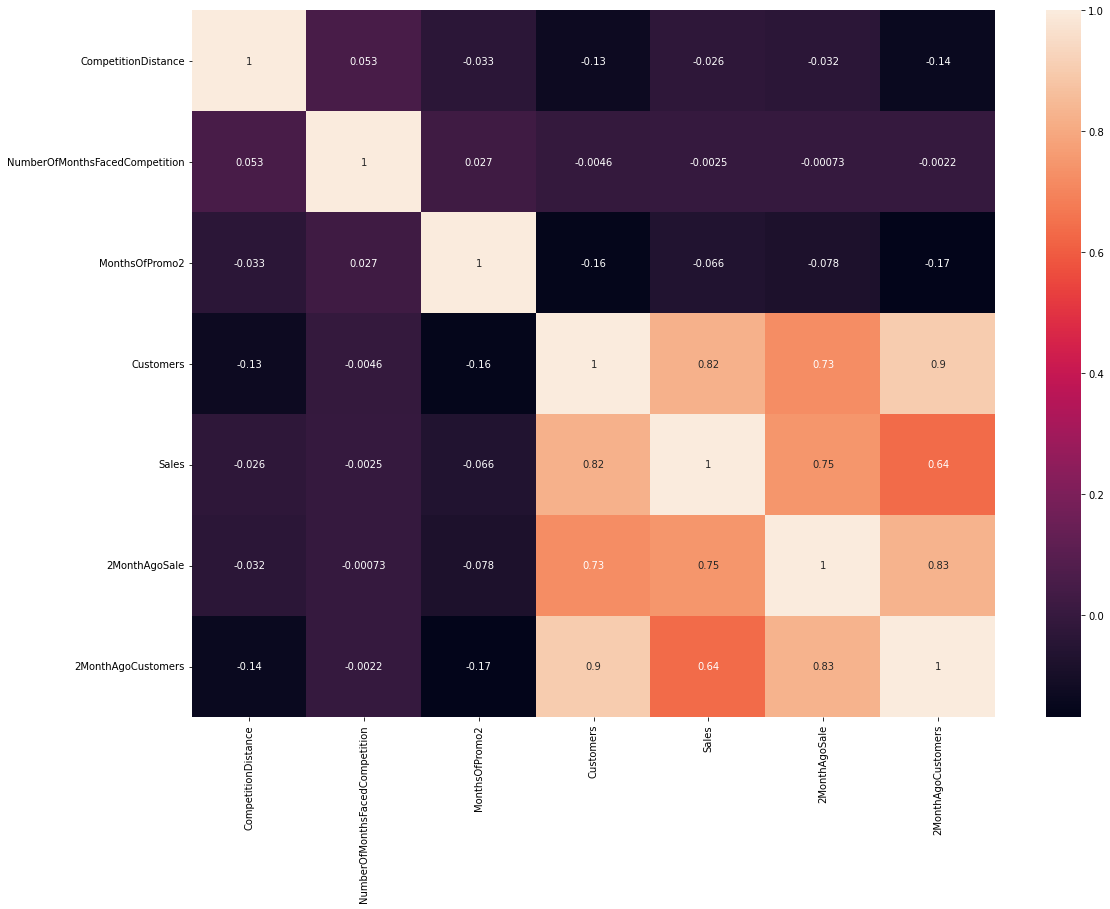

In [ ]:
plt.figure(figsize=(18, 13))
corr = rossmann_temp_df[numerical_features].corr()
sns.heatmap(corr , annot = True )

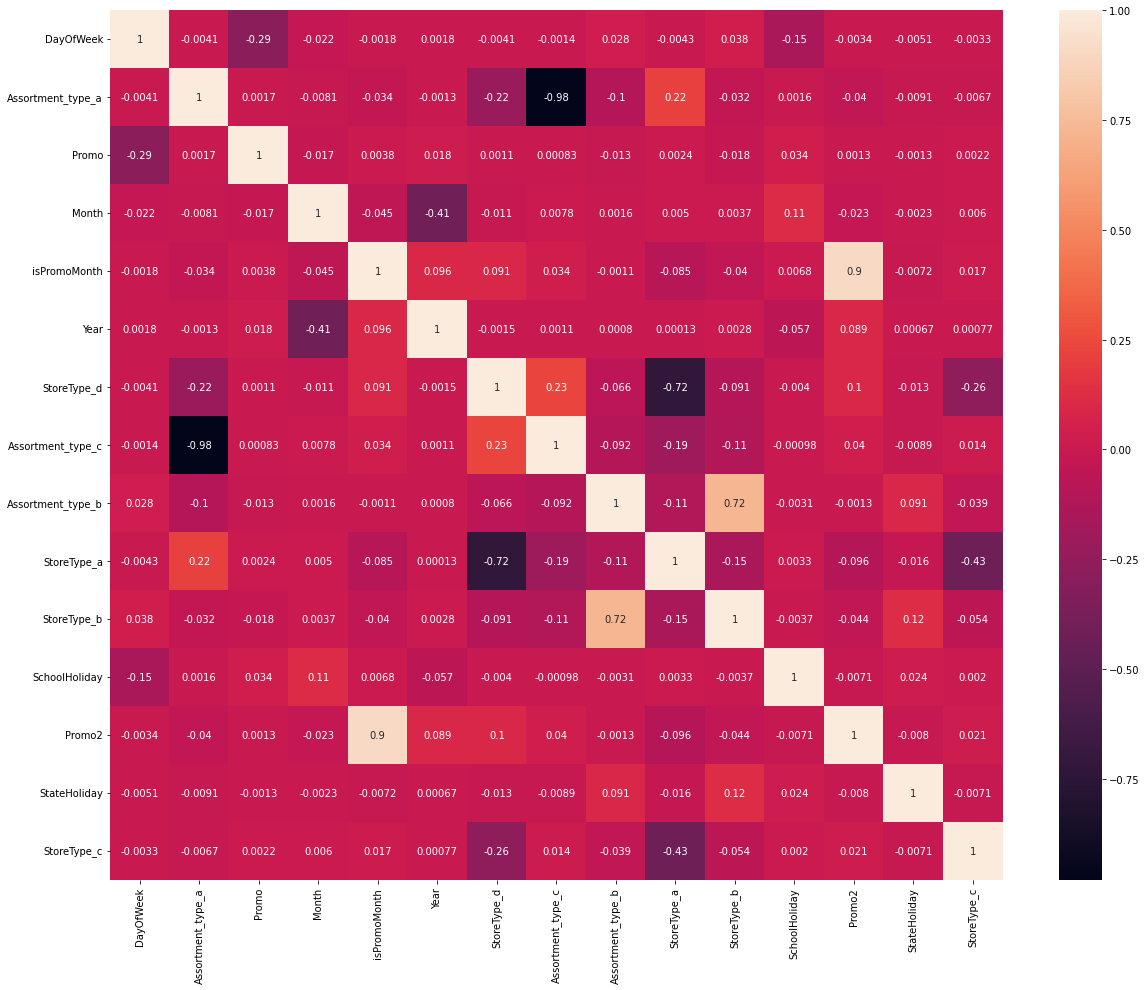

In [ ]:
plt.figure(figsize = (20,16))
otherFeatures = list(set(rossmann_temp_df.describe().columns) - set(numerical_features) - {"Store" , "Open"})
corr2 = rossmann_temp_df[otherFeatures].corr()
sns.heatmap(corr2 , annot = True)

In [ ]:
rossmann_temp_df.drop(["Open"] , axis = 1 , inplace = True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
correlation_features = ["CompetitionDistance" , "NumberOfMonthsFacedCompetition" , "MonthsOfPromo2" , "2MonthAgoSale" ]

In [ ]:
calc_vif(rossmann_temp_df[correlation_features])

,variables,VIF
0,CompetitionDistance,1.324816
1,NumberOfMonthsFacedCompetition,1.447870
2,MonthsOfPromo2,1.371282
3,2MonthAgoSale,1.936576


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
rossmann_temp_df.describe().columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'Promo2',
       'NumberOfMonthsFacedCompetition', 'isPromoMonth', 'MonthsOfPromo2',
       'Month', 'Year', '2MonthAgoSale', '2MonthAgoCustomers', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_type_a',
       'Assortment_type_b', 'Assortment_type_c'],
      dtype='object')

In [ ]:
independent_features = rossmann_temp_df.describe().columns
independent_features = list(set(independent_features) - { "Sales" , "Customers" , "StoreType_a" , "2MonthAgoCustomers" ,"Promo2" , "Assortment_type_a" })

In [ ]:
def train_test_split(df , dependent_feature , independent_features):
  
  break_point = round(len(df)*0.90)
  train_data = df.iloc[:break_point]
  test_data = df.iloc[break_point:]
  X_train = train_data[independent_features].copy()
  Y_train = train_data[dependent_feature].copy()
  X_test = test_data[independent_features].copy()
  Y_test = test_data[dependent_feature].copy()
  return (X_train ,Y_train ,X_test ,Y_test )

In [ ]:
def regression_results(Y_true, Y_pred , X_test):
  
  MSE  = mean_squared_error((Y_true), (Y_pred))
  RMSE = np.sqrt(MSE)
  MAE = mean_absolute_error((Y_true) ,(Y_pred))
  r2 = r2_score((Y_true), (Y_pred))
  Adjusted_r2 = 1-(1-r2_score((Y_true), (Y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))

  print("MSE : ", MSE)
  print("RMSE : ", RMSE)
  print("MAE : ", MAE)
  print("R2 : ", r2)
  print("Adjusted R2 : ", Adjusted_r2)

In [ ]:
def diffPlot(Y_true ,Y_pred):
  plt.figure(figsize=(8,5))
  plt.plot((Y_pred))
  plt.plot(((Y_true)))
  plt.legend(["Predicted","Actual"])
  plt.show()

In [ ]:
X_train ,Y_train ,X_test ,Y_test = train_test_split( rossmann_temp_df, "Sales" , independent_features)

In [ ]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
ridge  = Ridge(alpha= 100 , max_iter= 3000)

ridge.fit(X_train, Y_train)

Ridge(alpha=100, max_iter=3000)

In [ ]:
ridge.score(X_train , Y_train)

0.701107781405989

In [ ]:
Y_pred_ridge = ridge.predict(X_test)
regression_results(Y_test , Y_pred_ridge , X_test)

diffPlot(Y_test , Y_pred_ridge)

In [ ]:
ridge = Ridge()
tscv = TimeSeriesSplit(n_splits = 2,test_size=59104)

parameters = {'alpha': [1e-6 , 1e-7 , 1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,50,60,100,1000]}
ridge_regressor = GridSearchCV(ridge , param_grid = parameters, scoring= 'r2' , cv=tscv)
ridge_regressor.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=59104),
             estimator=Ridge(),
             param_grid={'alpha': [1e-06, 1e-07, 1e-05, 0.0001, 0.001, 0.01,
                                   0.1, 1, 5, 10, 20, 30, 40, 50, 60, 100,
                                   0.0014]},
             scoring='r2')

In [ ]:
Y_pred_ridge_grid = ridge_regressor.predict(X_test)
regression_results(Y_test , Y_pred_ridge_grid , X_test)

diffPlot(Y_test , Y_pred_ridge_grid)

In [ ]:
X_train ,Y_train ,X_test ,Y_test = train_test_split( rossmann_temp_df, "Sales" , independent_features)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

decision_reg = DecisionTreeRegressor(criterion = "squared_error" , max_depth = 13 , max_features = "auto" )
decision_reg.fit(X_train , Y_train)

DecisionTreeRegressor(max_depth=13, max_features='auto')

In [ ]:
decision_reg.score(X_train  , Y_train)

0.857392682300747

In [ ]:
Y_pred_dec = decision_reg.predict(X_test)
regression_results(Y_test, Y_pred_dec ,X_test)

diffPlot(Y_test , Y_pred_dec)

In [ ]:
gradient_reg = GradientBoostingRegressor()
gradient_reg.fit(X_train , Y_train)

GradientBoostingRegressor()

In [ ]:
gradient_reg.score(X_train , Y_train)

0.815378059121681

In [ ]:
Y_pred_grad =gradient_reg.predict(X_test)
regression_results(Y_test , Y_pred_grad , X_test)

diffPlot(Y_test , Y_pred_grad)

In [ ]:
model = GradientBoostingRegressor()
tscv = TimeSeriesSplit(n_splits = 2,test_size=59104)

grid_values = {
    "learning_rate" : [ 0.1 ],
    "n_estimators" : [ 110 ],
    "max_depth" : [3]
}

gradGridSearch = GridSearchCV( estimator = model , param_grid = grid_values , scoring = 'r2' , cv = tscv)
gradGridSearch.fit(X_train , Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=59104),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [110]},
             scoring='r2')

In [ ]:
gradGridSearch.best_score_

0.8021824502204853

In [ ]:
Y_pred_grad_grid = gradGridSearch.predict(X_test)
regression_results(Y_test ,Y_pred_grad_grid , X_test)

diffPlot(Y_test , Y_pred_grad_grid)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train , Y_train)

In [ ]:
rf_regressor.score(X_train, Y_train)

In [ ]:
Y_pred_rf = rf_regressor.predict(X_test)
regression_results(Y_test , Y_pred_rf , X_test)

diffPlot(Y_test , Y_pred_rf)

In [ ]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the RandomForestClassifier
rf_model = RandomForestClassifier()

# Grid search
rf_grid = GridSearchCV(estimator=rf_model,
                       param_grid = param_dict,
                       cv = 5, verbose=2, scoring='roc_auc')

rf_grid.fit(X_train,Y_train)

## Residual Analysis

In [ ]:
#Resuldual Analysis
fig=plt.figure(figsize=(8,8))
  
sns.distplot(((Y_test)- (y_pred_lasso)),bins=20,color='r')

#Plot Label
fig.suptitle('Residual Analysis', fontsize = 20)   

In [ ]:
### Heteroscadacity
plt.scatter((y_pred_lasso) , (Y_test) - (y_pred_lasso) , c='r')
plt.xlabel('Predicted selling price')
plt.ylabel('residuals')